In [1]:
import numpy as np
import rasterio.plot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import namedtuple
import numpy as np
from lxml import etree


from burst_translator import BurstMetadata

swath_tif = 'S1A_IW_SLC__1SDV_20200616T022252_20200616T022319_033036_03D3A3_5D11.SAFE/measurement/s1a-iw1-slc-vh-20200616t022253-20200616t022318-033036-03d3a3-001.tiff'
swath_ann = 'S1A_IW_SLC__1SDV_20200616T022252_20200616T022319_033036_03D3A3_5D11.SAFE/annotation/s1a-iw1-slc-vh-20200616t022253-20200616t022318-033036-03d3a3-001.xml'

In [2]:
offsets = namedtuple('offsets', 'start end')

# annotation xml
tree = etree.parse(swath_ann)

# number of lines in each burst
frame_lines = int(tree.xpath('./swathTiming/linesPerBurst/text()')[0])

burst_elements = tree.xpath('./swathTiming/burstList/burst')


In [3]:
def jason_get_bounds(index, burst):
    # all offsets, even invalid offsets
    offsets_range = offsets(
        np.array([int(val) for val in burst.xpath('firstValidSample/text()')[0].split()]),
        np.array([int(val) for val in burst.xpath('lastValidSample/text()')[0].split()]),
    )

    # returns the indices of lines containing valid data
    lines_with_valid_data = np.flatnonzero(offsets_range.end - offsets_range.start)

    # get first and last sample with valid data per line
    # x-axis, range
    valid_offsets_range = offsets(
        offsets_range.start[lines_with_valid_data].min(),
        offsets_range.end[lines_with_valid_data].max(),
    )

    # get the first and last line with valid data
    # y-axis, azimuth
    valid_offsets_azimuth = offsets(
        lines_with_valid_data.min(),
        lines_with_valid_data.max(),
    )

    # x-length
    length_range = valid_offsets_range.end - valid_offsets_range.start
    # y-length
    length_azimuth = len(lines_with_valid_data)

    # n-th burst * total lines + first azimuth
    # y-offset
    azimuth_start = index * frame_lines + valid_offsets_azimuth.start
 
    # [x-offset, y-offset, x-length, y-length]
    # window = [valid_offsets_range.start, azimuth_start, length_range, length_azimuth]
    return valid_offsets_range.start, azimuth_start, length_range, length_azimuth

In [4]:
isce_patches = []
jsn_patches = []
for ii, be in enumerate(burst_elements):
    burst = BurstMetadata(swath_tif, swath_ann, ii)
    x1, x2, y1, y2 = burst.get_bounds()
    w = x2-x1
    h = y2-y1+1  # FIXME: Correct?
    isce_patches.append(Rectangle((x1, y1), w, h, facecolor='none', edgecolor='Red'))
    isce_bounds = [x1, y1, w, h]
    
    jsn_bounds = jason_get_bounds(ii, be)
    x1, y1, w, h = jsn_bounds
    jsn_patches.append(Rectangle((x1, y1), w, h, facecolor='none', edgecolor='Yellow'))    

In [5]:
with rasterio.open(swath_tif) as swath:
    swath_data = swath.read()
magnitude = np.abs(swath_data)

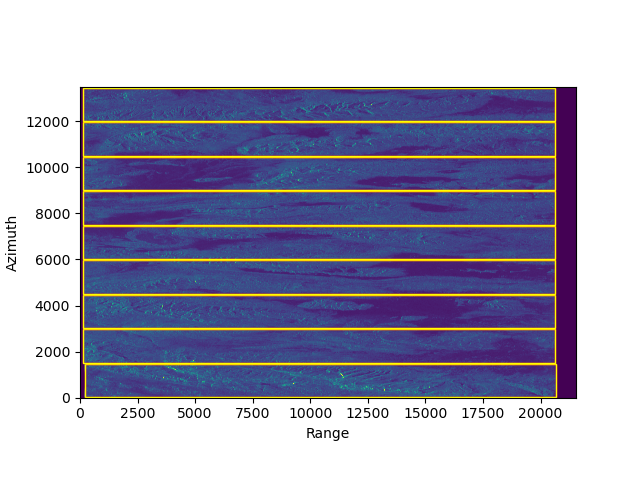

In [6]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
rasterio.plot.show(magnitude, ax=ax, vmin=0, vmax=250, cmap='viridis')

ax.set(xlabel='Range', ylabel='Azimuth')
ax.invert_yaxis()

for jr, ir in zip(jsn_patches, isce_patches):
    ax.add_patch(ir)
    ax.add_patch(jr)

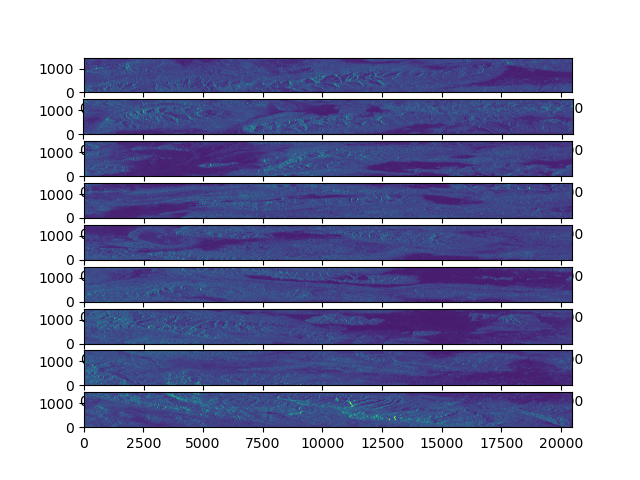

In [7]:
%matplotlib widget
fig, axes = plt.subplots(9, 1)
for ii in range(0, 9):
    with rasterio.open(f'burst{ii+1}.tiff') as bb:
        rasterio.plot.show(np.abs(bb.read(1)), ax=axes[::-1][ii], vmin=0, vmax=250, cmap='viridis')
        axes[::-1][ii].invert_yaxis()


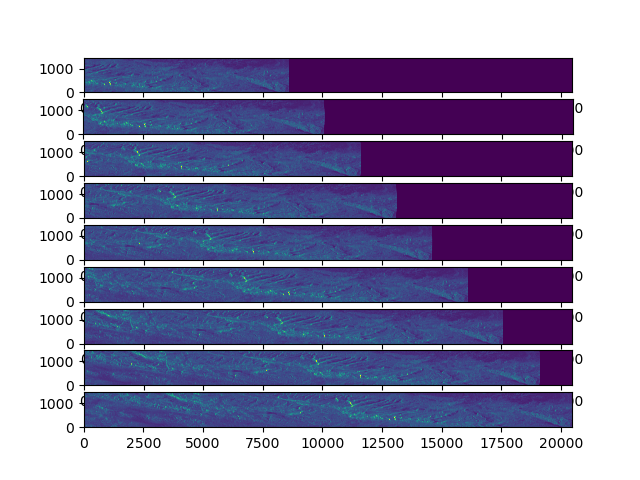

In [8]:
%matplotlib widget
fig, axes = plt.subplots(9, 1)
for ii in range(0, 9):
    with rasterio.open(f'burst{ii+1}-original.tiff') as bb:
        rasterio.plot.show(np.abs(bb.read(1)), ax=axes[::-1][ii], vmin=0, vmax=250, cmap='viridis')
        axes[::-1][ii].invert_yaxis()
